<a href="https://colab.research.google.com/github/saimathura/deeplearning-MDSC302/blob/main/assignment_dl_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# creating a small network to learn the pattern in MNIST dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



# Downloading The Data

In [ ]:

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 351552989.90it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 3407473.81it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 189731184.24it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19700650.23it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# loading THe Data

In [ ]:
from torch.utils.data import DataLoader

# Doing a Train Validation Split

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_size = int(0.9 * (len(training_data)))

In [ ]:
val_size = len(training_data) - train_size

In [ ]:
train_set , val_set = random_split(training_data, [train_size, val_size])

# Now the split is IN training Data Available we have split the data into 90% for trainig and 10% for Validation

In [ ]:
train_set.__len__()

54000

In [ ]:
val_set.__len__()

6000

In [ ]:
train_dataloader = DataLoader(train_set,batch_size = 64,shuffle = True)
val_dataloader = DataLoader(val_set,batch_size = 64,shuffle = True)
test_dataloader = DataLoader(test_data,batch_size = 64,shuffle = True)

In [ ]:
train_features,train_labels = next(iter(train_dataloader))

# Printing a Random Sample from the Data

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


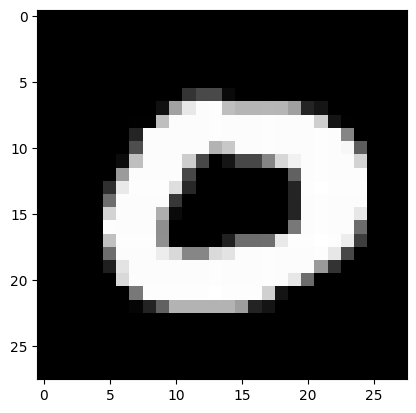

Label: 0


In [ ]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Creating THe Model

In [ ]:
from torch import nn

# Setting Cuda Device

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:

import torch.nn.functional as F

In [ ]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,4096)#just a random Neural Network with 6 Hidden Layers
        self.fc2 = nn.Linear(4096,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,32)
        self.fc6 = nn.Linear(32,10)

    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))# using a common Activation Function
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        output = F.softmax(self.fc6(x),dim = 1)# doing a softmax at the END
        return output


In [ ]:
model = net()# loading THe Model

# Loading the Model to CUDA (to Gpu)

In [ ]:
model.cuda()

net(
  (fc1): Linear(in_features=784, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
device = torch.device("cuda:0")
model.to(device)

net(
  (fc1): Linear(in_features=784, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# i know this is totally Random but I trained the model for 50 straight epochs!!

In [ ]:
epochs = 50  # You can adjust the number of epochs as needed

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []# for plotting

# Training The model

In [ ]:

for e in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0
    model.train()  # Set the model to training mode

    # Training loop
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:  # Assuming you have a DataLoader named 'val_loader'
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    # Calculate average losses for this epoch
    average_train_loss = train_loss / len(train_dataloader)
    average_val_loss = val_loss / len(val_dataloader)
    train_accuracy = train_correct / train_total * 100
    val_accuracy = val_correct / val_total * 100
    average_train_accuracy = train_accuracy / len(train_dataloader)
    average_val_accuracy = val_accuracy / len(val_dataloader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{e+1}/{epochs}],Train Accuracy: {average_train_accuracy:.4f}, Val Accuracy: {average_val_accuracy:.4f}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')

print("Training finished")

Epoch [1/50],Train Accuracy: 0.0230, Val Accuracy: 0.2098, Train Loss: 2.3003, Val Loss: 2.3002
Epoch [2/50],Train Accuracy: 0.0245, Val Accuracy: 0.2140, Train Loss: 2.2998, Val Loss: 2.2995
Epoch [3/50],Train Accuracy: 0.0247, Val Accuracy: 0.2138, Train Loss: 2.2990, Val Loss: 2.2986
Epoch [4/50],Train Accuracy: 0.0247, Val Accuracy: 0.2131, Train Loss: 2.2979, Val Loss: 2.2971
Epoch [5/50],Train Accuracy: 0.0247, Val Accuracy: 0.2133, Train Loss: 2.2961, Val Loss: 2.2945
Epoch [6/50],Train Accuracy: 0.0247, Val Accuracy: 0.2158, Train Loss: 2.2922, Val Loss: 2.2882
Epoch [7/50],Train Accuracy: 0.0281, Val Accuracy: 0.2319, Train Loss: 2.2770, Val Loss: 2.2503
Epoch [8/50],Train Accuracy: 0.0252, Val Accuracy: 0.2367, Train Loss: 2.2328, Val Loss: 2.2102
Epoch [9/50],Train Accuracy: 0.0297, Val Accuracy: 0.3418, Train Loss: 2.1852, Val Loss: 2.1433
Epoch [10/50],Train Accuracy: 0.0417, Val Accuracy: 0.3991, Train Loss: 2.1190, Val Loss: 2.0890
Epoch [11/50],Train Accuracy: 0.0453, V

# plotting the curves

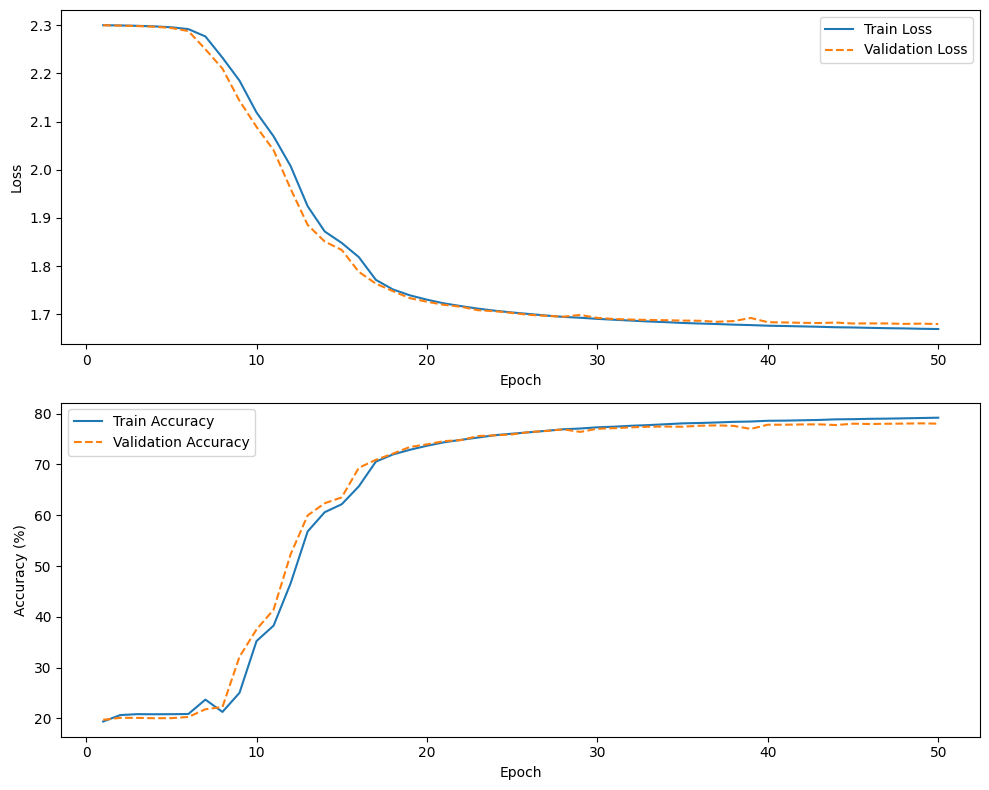

In [ ]:
# Plotting the loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(range(1, epochs+1), train_losses, label='Train Loss')
ax1.plot(range(1, epochs+1), val_losses, label='Validation Loss', linestyle='dashed')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', linestyle='dashed')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

# Testing The model

In [ ]:


model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_images, test_labels in test_dataloader:  # Assuming you have a DataLoader named 'test_loader'
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = model(test_images)
        test_loss += criterion(test_outputs, test_labels).item()
        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

average_test_loss = test_loss / len(test_dataloader)
test_accuracy = test_correct / test_total * 100

print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 1.6817, Test Accuracy: 77.82%
